In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
# name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"

dataset = datasets[name]

In [ ]:
results_final = {}

results_final["name"] = name
results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "early_stopping": early_stopping,
    "pca": pca,
    "digraph_centralities": digraph_centralities,
    "multi_graph_centralities": multi_graph_centralities,
    "learning_rate": learning_rate,
    "LAMBD_1": LAMBD_1,
    "LAMBD_2": LAMBD_2,
    "cfg": OmegaConf.to_container(cfg)
}

if pca:
    results_final["pca_columns"] = pca_columns
if digraph_centralities:
    results_final["centralities_columns"] = centralities_columns
    
results_final["baseline"] = {}
results_final["baseline"]["accuracy"] = {}
results_final["baseline"]["f1s"] = {}

results_final["PCA"] = {}
results_final["PCA"]["accuracy"] = {}
results_final["PCA"]["f1s"] = {}

results_final["digraph"] = {}
results_final["digraph"]["accuracy"] = {}
results_final["digraph"]["f1s"] = {}

results_final["multidigraph"] = {}
results_final["multidigraph"]["accuracy"] = {}
results_final["multidigraph"]["f1s"] = {}

results_final

In [ ]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

In [ ]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

In [3]:
with open("datasets/" + name + "/training_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [4]:
G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [5]:
num_features = G.edata['h'].shape[1]
num_features

38

In [6]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [7]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [8]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [9]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [10]:
def train_gnn(model_class, Graph, residual, num_neighbors = None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters())

    for epoch in range(1,num_epochs):
    #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features,edge_features)
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [11]:
model_gcn = train_gnn(EGCN, G, False, None)

Epoch: 1  Training acc: 0.7877889275550842
Epoch: 2  Training acc: 0.8145761489868164
Epoch: 3  Training acc: 0.9536355137825012
Epoch: 4  Training acc: 0.9544575810432434
Epoch: 5  Training acc: 0.9539905786514282
Epoch: 6  Training acc: 0.9552489519119263
Epoch: 7  Training acc: 0.9545043110847473
Epoch: 8  Training acc: 0.9527902007102966
Epoch: 9  Training acc: 0.9551376104354858
Epoch: 10  Training acc: 0.9555343389511108
Epoch: 11  Training acc: 0.9550721645355225
Epoch: 12  Training acc: 0.9567750692367554
Epoch: 13  Training acc: 0.95674729347229
Epoch: 14  Training acc: 0.9566629528999329
Epoch: 15  Training acc: 0.9571598172187805
Epoch: 16  Training acc: 0.9763473272323608
Epoch: 17  Training acc: 0.976394534111023
Epoch: 18  Training acc: 0.9759665727615356
Epoch: 19  Training acc: 0.9757105112075806
Epoch: 20  Training acc: 0.976821780204773
Epoch: 21  Training acc: 0.9774240851402283
Epoch: 22  Training acc: 0.9806947708129883
Epoch: 23  Training acc: 0.9800753593444824
E

### Training EGCN residual

In [12]:
model_gcn_res = train_gnn(EGCN, G, True, None)

Epoch: 1  Training acc: 0.45719799399375916
Epoch: 2  Training acc: 0.6752612590789795
Epoch: 3  Training acc: 0.934879720211029
Epoch: 4  Training acc: 0.9495195150375366
Epoch: 5  Training acc: 0.9545277953147888
Epoch: 6  Training acc: 0.9550324082374573
Epoch: 7  Training acc: 0.9559302926063538
Epoch: 8  Training acc: 0.9693376421928406
Epoch: 9  Training acc: 0.9628283381462097
Epoch: 10  Training acc: 0.9764153957366943
Epoch: 11  Training acc: 0.9758747220039368
Epoch: 12  Training acc: 0.9760749936103821
Epoch: 13  Training acc: 0.9765387177467346
Epoch: 14  Training acc: 0.9741715788841248
Epoch: 15  Training acc: 0.9779220223426819
Epoch: 16  Training acc: 0.9767606258392334
Epoch: 17  Training acc: 0.9797549247741699
Epoch: 18  Training acc: 0.9781954288482666
Epoch: 19  Training acc: 0.9765518307685852
Epoch: 20  Training acc: 0.9768927693367004
Epoch: 21  Training acc: 0.9793750047683716
Epoch: 22  Training acc: 0.9792706370353699
Epoch: 23  Training acc: 0.98038023710250

### Training EGraphSage 

In [13]:
model_sage = train_gnn(EGRAPHSAGE, G, False, 4)

Epoch: 1  Training acc: 0.6051573157310486
Epoch: 2  Training acc: 0.8079562783241272
Epoch: 3  Training acc: 0.956001877784729
Epoch: 4  Training acc: 0.9553536176681519
Epoch: 5  Training acc: 0.9387871623039246
Epoch: 6  Training acc: 0.9551995396614075
Epoch: 7  Training acc: 0.9558956027030945
Epoch: 8  Training acc: 0.9740933179855347
Epoch: 9  Training acc: 0.9562435150146484
Epoch: 10  Training acc: 0.9552620053291321
Epoch: 11  Training acc: 0.9753215312957764
Epoch: 12  Training acc: 0.9777970910072327
Epoch: 13  Training acc: 0.974599301815033
Epoch: 14  Training acc: 0.9762546420097351
Epoch: 15  Training acc: 0.9581484794616699
Epoch: 16  Training acc: 0.9780400395393372
Epoch: 17  Training acc: 0.9763190150260925
Epoch: 18  Training acc: 0.976736307144165
Epoch: 19  Training acc: 0.9757030606269836
Epoch: 20  Training acc: 0.9759577512741089
Epoch: 21  Training acc: 0.976260244846344
Epoch: 22  Training acc: 0.975341796875
Epoch: 23  Training acc: 0.9783868789672852
Epoch

### Training EGraphSage residual

In [14]:
model_sage_res = train_gnn(EGRAPHSAGE, G, True, 4)

Epoch: 1  Training acc: 0.4407810866832733
Epoch: 2  Training acc: 0.6634671092033386
Epoch: 3  Training acc: 0.7666873931884766
Epoch: 4  Training acc: 0.9086251854896545
Epoch: 5  Training acc: 0.871250331401825
Epoch: 6  Training acc: 0.9448820948600769
Epoch: 7  Training acc: 0.9702280759811401
Epoch: 8  Training acc: 0.9689812064170837
Epoch: 9  Training acc: 0.9726942777633667
Epoch: 10  Training acc: 0.9651647806167603
Epoch: 11  Training acc: 0.9725765585899353
Epoch: 12  Training acc: 0.9741075038909912
Epoch: 13  Training acc: 0.9739104509353638
Epoch: 14  Training acc: 0.9748753905296326
Epoch: 15  Training acc: 0.9760530591011047
Epoch: 16  Training acc: 0.9769445657730103
Epoch: 17  Training acc: 0.9590829610824585
Epoch: 18  Training acc: 0.9748134016990662
Epoch: 19  Training acc: 0.9771034121513367
Epoch: 20  Training acc: 0.9782707095146179
Epoch: 21  Training acc: 0.9754891991615295
Epoch: 22  Training acc: 0.9803410172462463
Epoch: 23  Training acc: 0.980294823646545

### Training EGAT

In [15]:
# model_gat = train_gnn(EGAT, G, False, None)

### Training EGAT residual

In [16]:
# model_gat_res = train_gnn(EGAT, G, True, None)

# Testing

In [17]:
with open("datasets/" + name + "/testing_graph.pkl", "rb") as f:
    G_test = pickle.load(f)

In [18]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [19]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [20]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [21]:
def test_gnn(model, graph):
    start_time = timeit.default_timer()
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred)


In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Testing EGCN

In [23]:
actual, test_pred = test_gnn(model_gcn, G_test)

1.8588082008063793 seconds


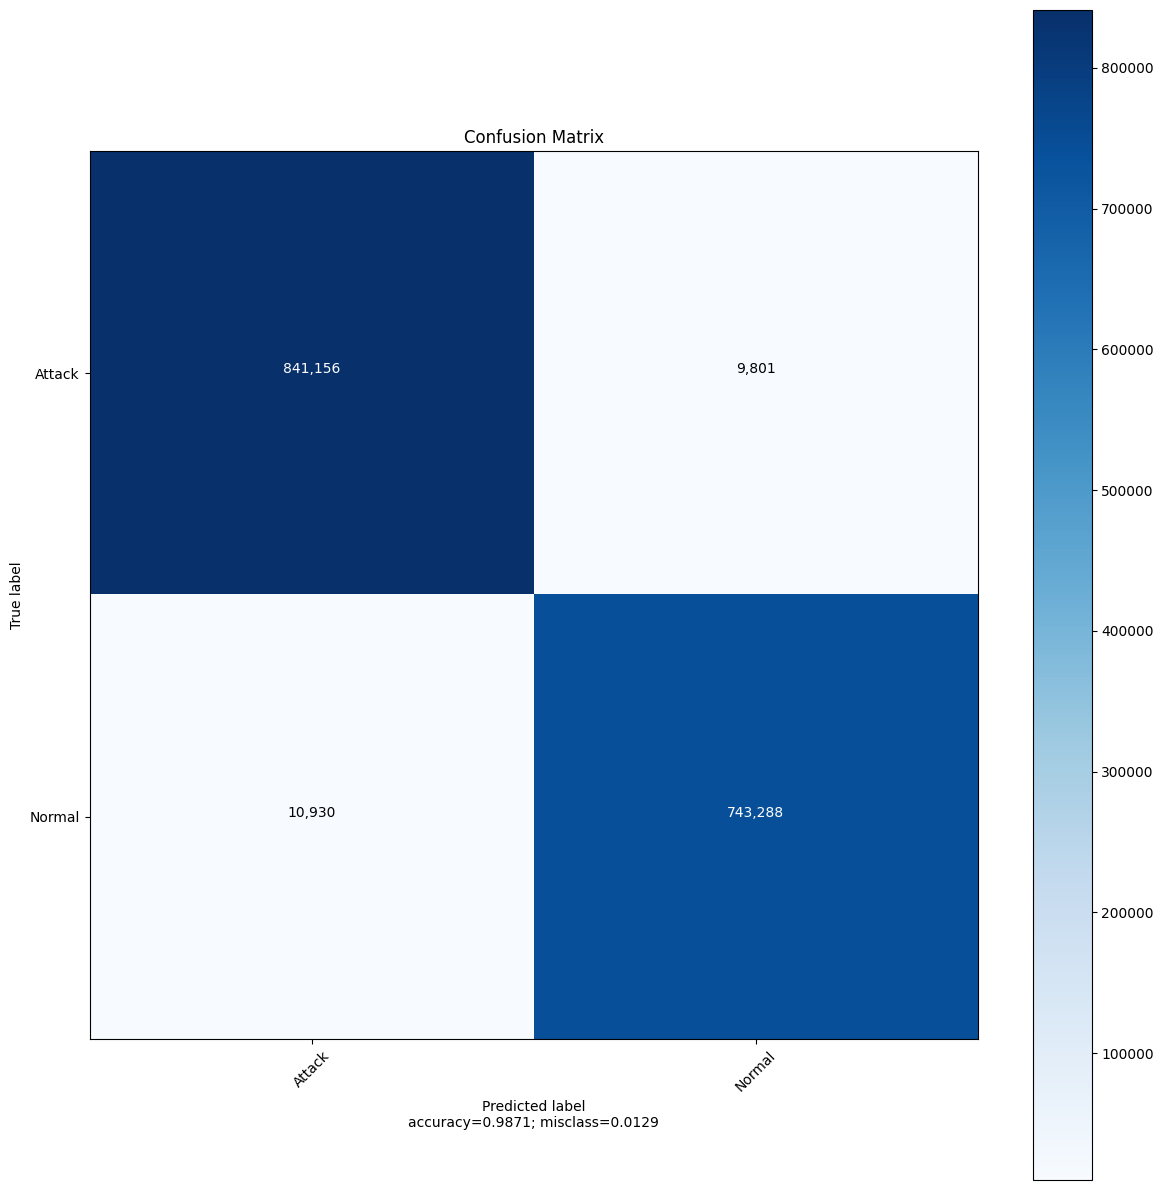

In [24]:
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [25]:
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9872    0.9885    0.9878    850957
      Normal     0.9870    0.9855    0.9862    754218

    accuracy                         0.9871   1605175
   macro avg     0.9871    0.9870    0.9870   1605175
weighted avg     0.9871    0.9871    0.9871   1605175



### Testing EGCN residual

In [26]:
actual, test_pred = test_gnn(model_gcn_res, G_test)

2.0991989001631737 seconds


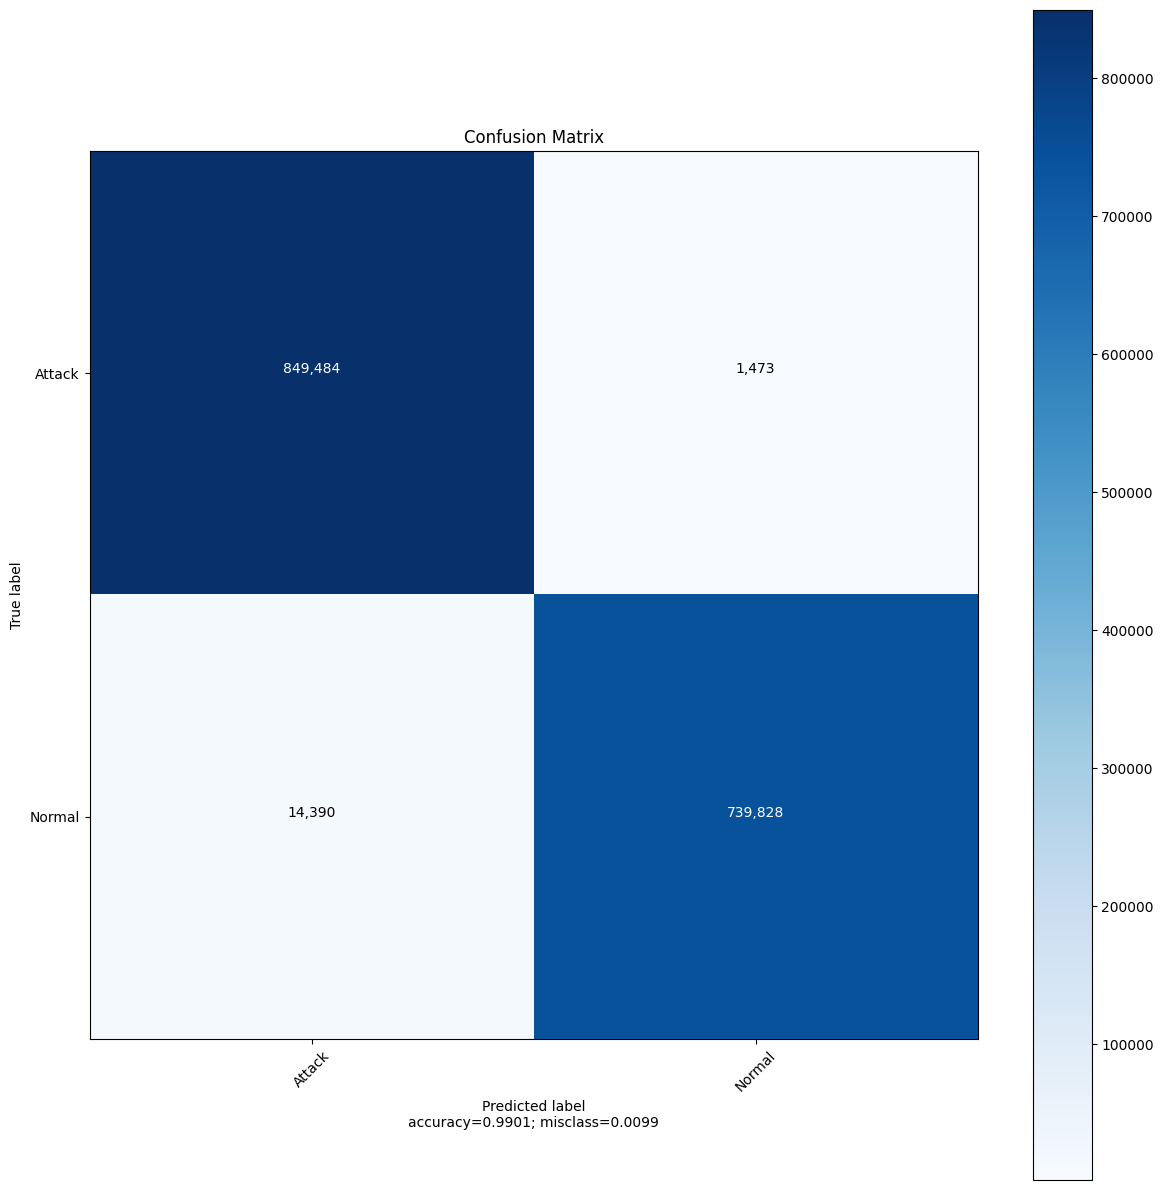

In [27]:
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [28]:
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9833    0.9983    0.9907    850957
      Normal     0.9980    0.9809    0.9894    754218

    accuracy                         0.9901   1605175
   macro avg     0.9907    0.9896    0.9901   1605175
weighted avg     0.9902    0.9901    0.9901   1605175



### Testing EGraphSage

In [29]:
actual, test_pred = test_gnn(model_sage, G_test)

1.2034767996519804 seconds


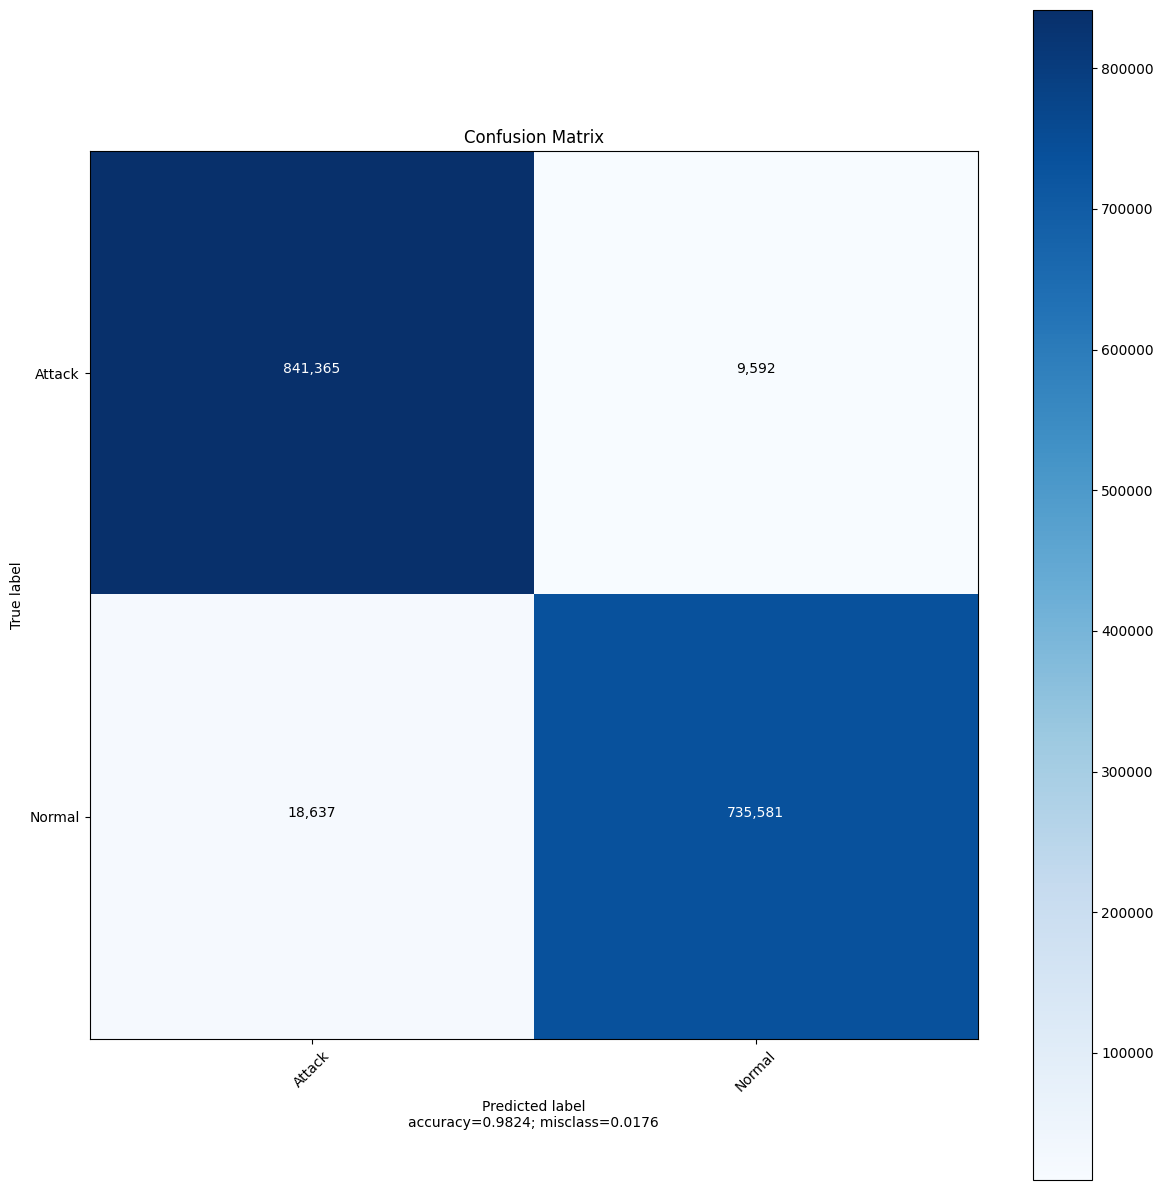

In [30]:
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [31]:
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9783    0.9887    0.9835    850957
      Normal     0.9871    0.9753    0.9812    754218

    accuracy                         0.9824   1605175
   macro avg     0.9827    0.9820    0.9823   1605175
weighted avg     0.9825    0.9824    0.9824   1605175



### Testing EGraphSage residual

In [32]:
actual, test_pred = test_gnn(model_sage_res, G_test)

0.7810510005801916 seconds


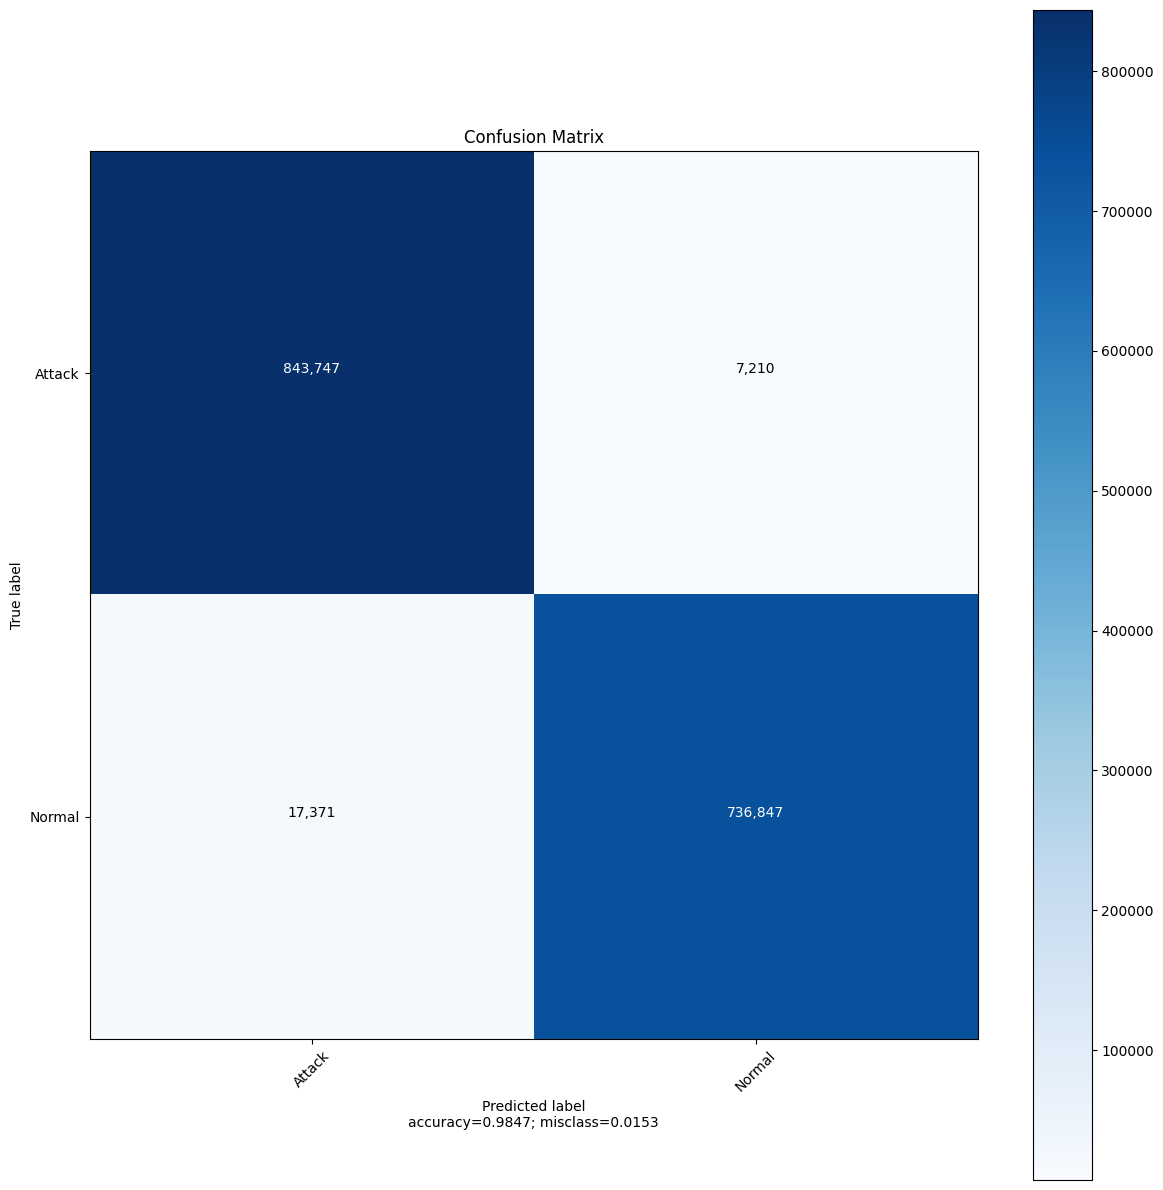

In [33]:
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [34]:
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9798    0.9915    0.9856    850957
      Normal     0.9903    0.9770    0.9836    754218

    accuracy                         0.9847   1605175
   macro avg     0.9851    0.9842    0.9846   1605175
weighted avg     0.9848    0.9847    0.9847   1605175



### Testing EGAT

In [35]:
# actual, test_pred = test_gnn(model_gat, G_test)

In [36]:
# plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
#                       normalize    = False,
#                       target_names = np.unique(actual),
#                       title        = "Confusion Matrix")

In [37]:
# print(classification_report(actual, test_pred, digits=4))

### Testing EGAT residual

In [38]:
# actual, test_pred = test_gnn(model_gat_res, G_test)

In [39]:
# plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
#                       normalize    = False,
#                       target_names = np.unique(actual),
#                       title        = "Confusion Matrix")

In [40]:
# print(classification_report(actual, test_pred, digits=4))